In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cf_units, datetime
import numpy as np
from notebook_metadata import create_savefig

In [2]:
d = xr.open_dataset('/g/data/qv56/replicas/input4MIPs/CMIP7/CMIP/uoexeter/UOEXETER-CMIP-2-2-1/atmos/mon/ext/gnz/v20250521/ext_input4MIPs_aerosolProperties_CMIP_UOEXETER-CMIP-2-2-1_gnz_175001-202312.nc')

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [3]:
# Why does this return a 2D array?
w550 = np.argwhere(d.wavelength.data==550e-9)[0,0]

lat_wts = np.diff(np.sin(np.radians(d.lat_bnds)), axis=1)
lat_wts.shape = (len(d.lat),)
lat_wts /= lat_wts.sum()

In [4]:
ext_g = (d.ext[:,:,:,w550] * lat_wts[:, np.newaxis]).sum('lat')

Text(0, 0.5, 'Height')

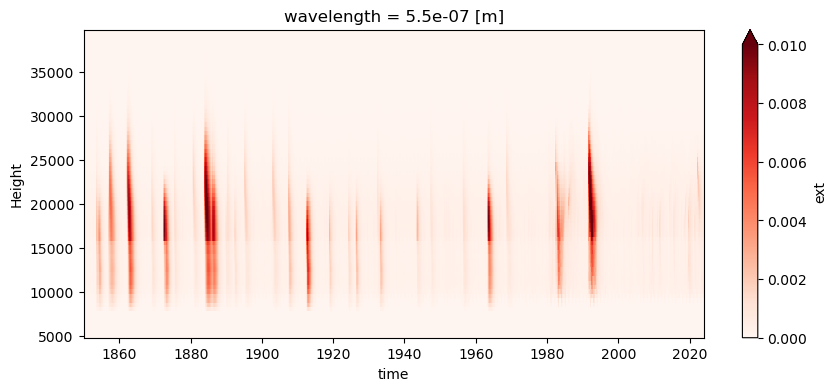

In [5]:
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(1,1,1)
(1000*ext_g[1200:]).plot(cmap='Reds', x='time', vmax=0.01)
axes.set_ylabel('Height')

In [6]:
thick = d.height_bnds[:,1] - d.height_bnds[:,0]

-80353 18993


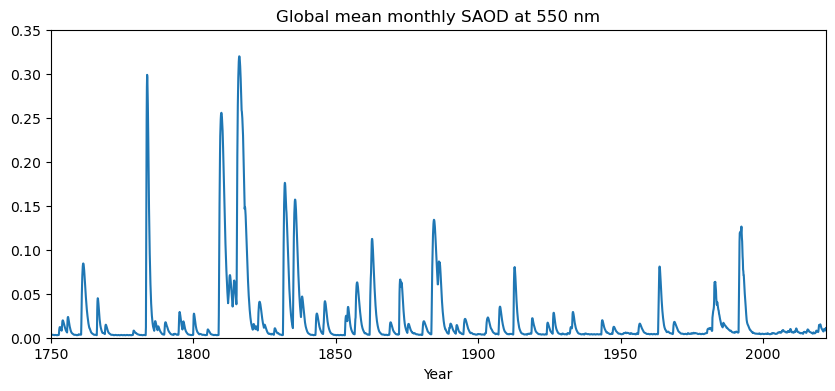

In [7]:
ext_tot = (ext_g * thick).sum('height')
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(1,1,1)
ext_tot.plot()
axes.set_title('Global mean monthly SAOD at 550 nm')
axes.set_xlabel('Year')
axes.set_ylim(0,0.35)
taxis = cf_units.Unit("days since 1970-01-01 00:00", calendar="proleptic_gregorian")
t0 = taxis.date2num(datetime.datetime(1750,1,1,0,0,0))
t1 = taxis.date2num(datetime.datetime(2022,1,1,0,0,0))
print(t0, t1)
axes.set_xlim(t0,t1)
_ = axes.set_xticks([taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(1750,2001,50)])

In [8]:
# Sum over height
ext_tot = (d.ext[:,:,:,w550] * thick).sum('height').sel(time=slice('1850', None))

# Equal area latitude bands used by ESM
bands = [slice(30,90), slice(0,30), slice(-30,0), slice(-90,-30)]
ext_band = np.zeros((len(ext_tot),4))
for b, band in enumerate(bands):
    # Factor of 4 for global area / band area
    ext_band[:,b] = 4*(ext_tot*lat_wts).sel(lat=band).sum('lat')

lat_band = xr.IndexVariable('band', [1,2,3,4])
ext_band = xr.DataArray(ext_band, coords=[ext_tot.time, lat_band])

od_cmip7 = ext_band.mean('band')


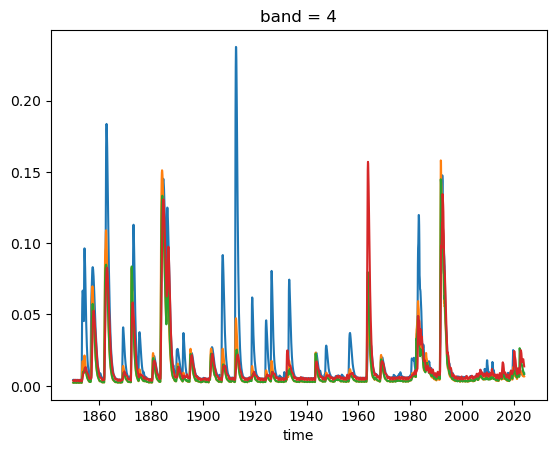

In [9]:
for b in range(4):
    ext_band[:,b].plot()


In [ ]:
esm_cmip6 = np.loadtxt('/g/data/vk83/experiments/inputs/access-esm1p5/modern/historical/atmosphere/forcing/resolution_independent/2021.06.22/volcts_cmip6.dat')
esm_cmip6_od = esm_cmip6[:,2:].mean(axis=1)

# Comparison with Paul's version
esm_cmip7 = np.loadtxt('/g/data/tm70/pcl851/CMIP7/esm1p6_ancil/2025.12.01/modern/historical/atmosphere/forcing/resolution_independent/2025.12.01/volcts_cmip7.dat')
esm_cmip7_od = esm_cmip7[:,2:].mean(axis=1)

# Mid month times
esm_time = esm_cmip6[:,0] + (esm_cmip6[:,1]-0.5)/12.


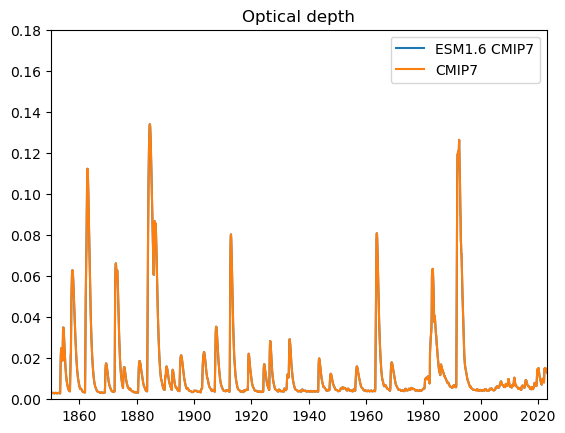

In [11]:
fig, axes = plt.subplots()
# plt.plot(esm_time,esm_cmip6_od*1e-4,label='ESM1.5 CMIP6')
plt.plot(esm_time,esm_cmip7_od*1e-4,label='ESM1.6 CMIP7')
axes.set_title('Optical depth')

plt.plot(esm_time[:len(od_cmip7)], od_cmip7, label='CMIP7')

axes.set_xlim(1850,2023)
# axes.set_xlim(1963,1965)
axes.set_ylim(0,0.18)
axes.legend()

(1850.0, 2023.0)

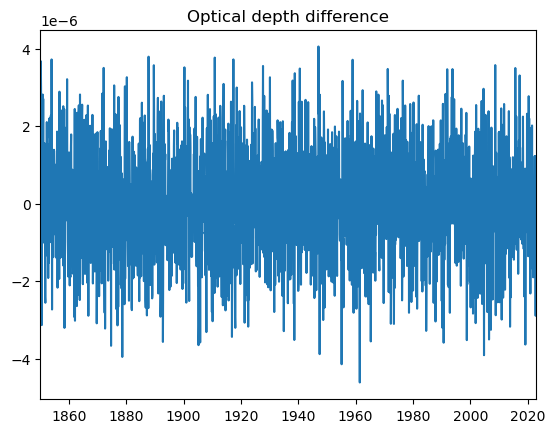

In [12]:
fig, axes = plt.subplots()
axes.set_title('Optical depth difference')

plt.plot(esm_time[:len(od_cmip7)], esm_cmip7_od[:2088]*1e-4-od_cmip7)

axes.set_xlim(1850,2023)


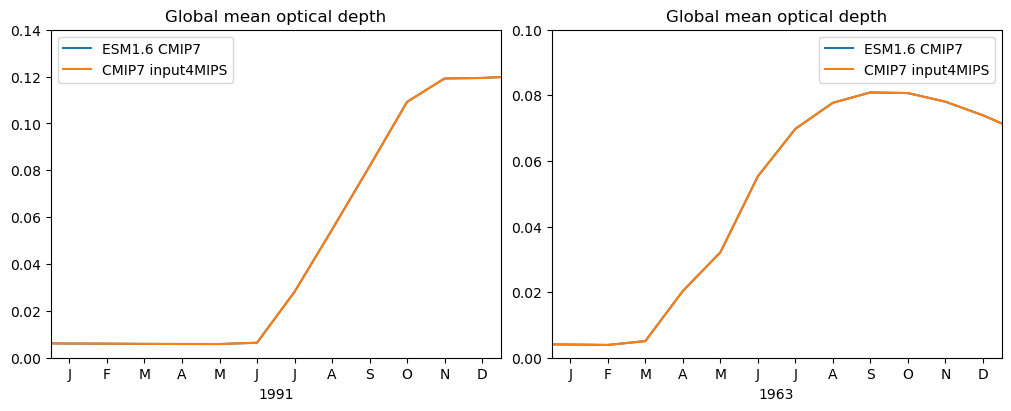

In [13]:
mosaic = [ ['a', 'b']]
fig, axes = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(10,4))

ax = axes['a']
# ax.plot(esm_time,esm_cmip6_od*1e-4,label='ESM1.5 CMIP6')
ax.plot(esm_time,esm_cmip7_od*1e-4,label='ESM1.6 CMIP7')
ax.set_title('Global mean optical depth')

ax.plot(esm_time[:len(od_cmip7)], od_cmip7, label='CMIP7 input4MIPS')

ax.set_xlim(1991,1992)
ax.set_xticks(1991 + np.arange(1,24,2)/24.)
ax.set_xticklabels(['J','F', 'M', 'A', 'M' ,'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_xlabel('1991')
ax.set_ylim(0,0.14)
ax.legend()

ax = axes['b']
# ax.plot(esm_time,esm_cmip6_od*1e-4,label='ESM1.5 CMIP6')
ax.plot(esm_time,esm_cmip7_od*1e-4,label='ESM1.6 CMIP7')
ax.set_title('Global mean optical depth')

ax.plot(esm_time[:len(od_cmip7)], od_cmip7, label='CMIP7 input4MIPS')

ax.set_xlim(1963,1964)
ax.set_xticks(1963 + np.arange(1,24,2)/24.)
ax.set_xticklabels(['J','F', 'M', 'A', 'M' ,'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_xlabel('1963')
ax.set_ylim(0,0.10)
ax.legend()

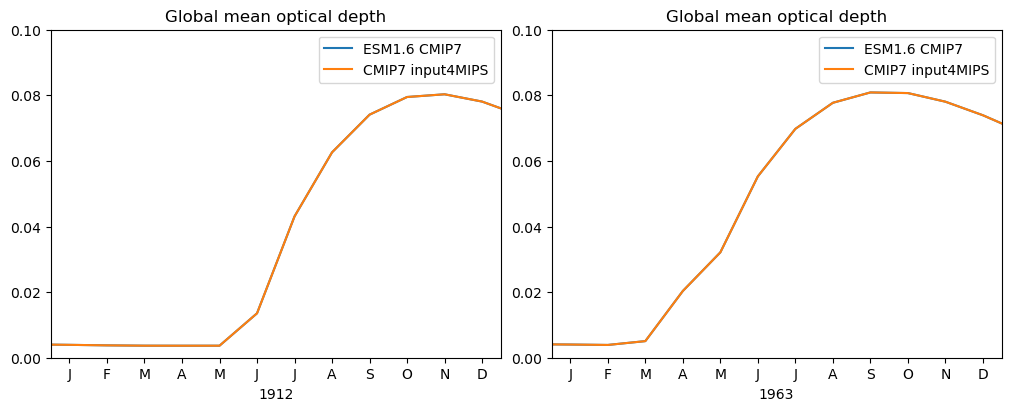

In [14]:
mosaic = [ ['a', 'b']]
fig, axes = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(10,4))

ax = axes['a']
# ax.plot(esm_time,esm_cmip6_od*1e-4,label='ESM1.5 CMIP6')
ax.plot(esm_time,esm_cmip7_od*1e-4,label='ESM1.6 CMIP7')
ax.set_title('Global mean optical depth')

ax.plot(esm_time[:len(od_cmip7)], od_cmip7, label='CMIP7 input4MIPS')

ax.set_xlim(1912,1913)
ax.set_xticks(1912 + np.arange(1,24,2)/24.)
ax.set_xticklabels(['J','F', 'M', 'A', 'M' ,'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_xlabel('1912')
ax.set_ylim(0,0.10)
ax.legend()

ax = axes['b']
# ax.plot(esm_time,esm_cmip6_od*1e-4,label='ESM1.5 CMIP6')
ax.plot(esm_time,esm_cmip7_od*1e-4,label='ESM1.6 CMIP7')
ax.set_title('Global mean optical depth')

ax.plot(esm_time[:len(od_cmip7)], od_cmip7, label='CMIP7 input4MIPS')

ax.set_xlim(1963,1964)
ax.set_xticks(1963 + np.arange(1,24,2)/24.)
ax.set_xticklabels(['J','F', 'M', 'A', 'M' ,'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_xlabel('1963')
ax.set_ylim(0,0.10)
ax.legend()

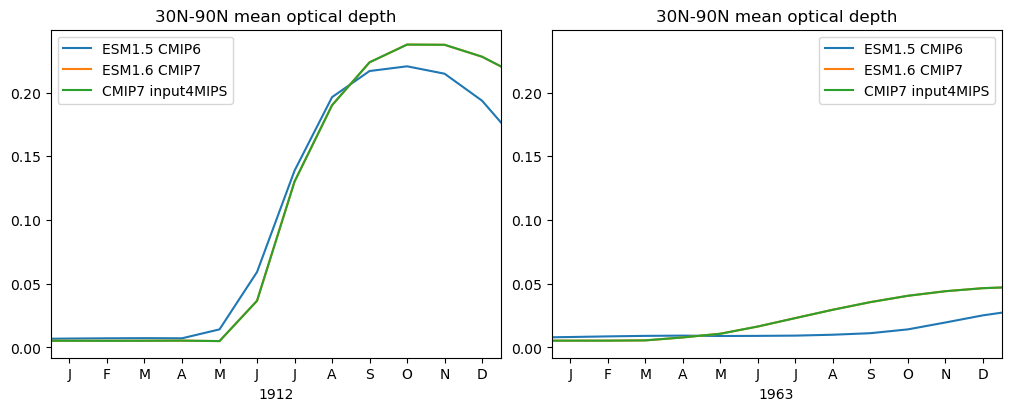

In [15]:
mosaic = [ ['a', 'b']]
fig, axes = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(10,4))

ax = axes['a']
ax.plot(esm_time,esm_cmip6[:,2]*1e-4,label='ESM1.5 CMIP6')
ax.plot(esm_time,esm_cmip7[:,2]*1e-4,label='ESM1.6 CMIP7')
ax.set_title('30N-90N mean optical depth')

ax.plot(esm_time[:len(ext_band)], ext_band[:,0], label='CMIP7 input4MIPS')


ax.set_xlim(1912,1913)
ax.set_xticks(1912 + np.arange(1,24,2)/24.)
ax.set_xticklabels(['J','F', 'M', 'A', 'M' ,'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_xlabel('1912')
# ax.set_ylim(0,0.10)
ax.legend()

ax = axes['b']
ax.plot(esm_time,esm_cmip6[:,2]*1e-4,label='ESM1.5 CMIP6')
ax.plot(esm_time,esm_cmip7[:,2]*1e-4,label='ESM1.6 CMIP7')
ax.set_title('30N-90N mean optical depth')

ax.plot(esm_time[:len(ext_band)], ext_band[:,0], label='CMIP7 input4MIPS')

ax.set_xlim(1963,1964)
ax.set_xticks(1963 + np.arange(1,24,2)/24.)
ax.set_xticklabels(['J','F', 'M', 'A', 'M' ,'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_xlabel('1963')
# ax.set_ylim(0,0.10)
ax.legend()

Text(0.5, 1.0, 'CMIP7 input4MIPs Volcanic AOD at 550 nm')

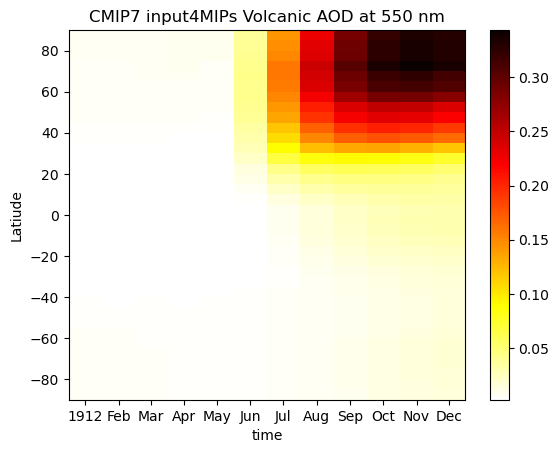

In [16]:
ext_col = (d.ext[:,:,:,w550] * thick).sum('height').compute()
fig, axes = plt.subplots()
ext_col.sel(time=slice("1912-01","1912-12")).plot(x='time', cmap='hot_r')
axes.set_ylabel('Latiude')
axes.set_title('CMIP7 input4MIPs Volcanic AOD at 550 nm')